In [1]:
import os

import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import stats

from Constants import Constants as const

In [2]:
# Step 1: Load the data and create event time variable
file_path = os.path.join(const.RESULT_PATH, '20250113_stock_act_data_v5.dta')
df = pd.read_stata(file_path).copy()

C:\Users\wangy\AppData\Local\Temp\ipykernel_32088\1387148850.py:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path).copy()


In [3]:
# Columns to be included in the analysis
columns = [
    "log_frequency_w", "log_frequency_ann_w", "log_frequency_qtr_w", "log_frequency_eps_w", "log_frequency_noneps_w", "log_frequency_day_w", 
    "env_info_w", "social_info_w", "width_w", "cpie_gpin", "cpie_owr", "SYNCHRONICITY_MONTH", "SYNCHRONICITY_MKT_MONTH", 
    "SYNCHRONICITY_IND_MONTH", "numest_last", "FCSTERROR_last", "DISPERSION_last", 
    "log_market_value_w", "lev_w", "BM_w", "ROA_w", "LOSS", "EarnVol_w", "ret_w", "turnover_w", "StkVol_w"
]


In [4]:
# Split the data into two parts based on fiscal_year
before_2012_df = df[df['fiscal_year'] < 2012]
after_2012_df = df[df['fiscal_year'] >= 2012]

In [5]:
# Function to perform comparison between treatment and control groups
def perform_comparison(df, columns):
    treatment_group = df[df['MajorGovCustomer'] == 1]
    control_group = df[df['MajorGovCustomer'] == 0]

    results = []

    for col in columns:
        treat_mean = treatment_group[col].mean()
        treat_median = treatment_group[col].median()
        treat_num = treatment_group[col].count()

        control_mean = control_group[col].mean()
        control_median = control_group[col].median()
        control_num = control_group[col].count()

        diff_mean = treat_mean - control_mean
        t_stat, p_value = stats.ttest_ind(treatment_group[col].dropna(), control_group[col].dropna(), equal_var=False)

        # Determine significance level
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''

        # Round values to three significant digits
        treat_mean = round(treat_mean, 3)
        treat_median = round(treat_median, 3)
        control_mean = round(control_mean, 3)
        control_median = round(control_median, 3)
        diff_mean = round(diff_mean, 3)
        t_stat = f"({round(t_stat, 3)})"

        results.append([treat_mean, treat_median, treat_num, control_mean, control_median, control_num, diff_mean, t_stat, significance])

    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=[
        "Treatment Mean", "Treatment Median", "Treatment N", 
        "Control Mean", "Control Median", "Control N", 
        "Difference in Mean", "t-stat", "Significance"
    ], index=columns)
    return results_df

In [6]:
# Perform comparison for data before 2012
results_before_2012 = perform_comparison(before_2012_df, columns)
print("Results for data before 2012:")
print(results_before_2012)


Results for data before 2012:
                         Treatment Mean  Treatment Median  Treatment N  \
log_frequency_w                   0.752             0.000          933   
log_frequency_ann_w               0.684             0.000          933   
log_frequency_qtr_w               0.225             0.000          933   
log_frequency_eps_w               0.351             0.000          933   
log_frequency_noneps_w            0.656             0.000          933   
log_frequency_day_w               0.545             0.000          933   
env_info_w                        3.815             0.000          933   
social_info_w                    11.170            12.023          933   
width_w                           0.689             0.800          209   
cpie_gpin                         0.426             0.474          517   
cpie_owr                          0.427             0.477          517   
SYNCHRONICITY_MONTH               1.583             1.520          612   
SYNCHRON

In [7]:
results_before_2012.to_excel(os.path.join(const.REGRESSION_RESULT_PATH, '20250126', 'T2PA TvC before 2012.xlsx'))

In [8]:
# Perform comparison for data from 2012 onwards
results_after_2012 = perform_comparison(after_2012_df, columns)
print("Results for data from 2012 onwards:")
print(results_after_2012)

Results for data from 2012 onwards:
                         Treatment Mean  Treatment Median  Treatment N  \
log_frequency_w                   0.750             0.000          921   
log_frequency_ann_w               0.676             0.000          921   
log_frequency_qtr_w               0.229             0.000          921   
log_frequency_eps_w               0.363             0.000          921   
log_frequency_noneps_w            0.651             0.000          921   
log_frequency_day_w               0.545             0.000          921   
env_info_w                        3.180             0.000          921   
social_info_w                    11.640            12.616          921   
width_w                           0.732             0.800          139   
cpie_gpin                         0.453             0.486          657   
cpie_owr                          0.417             0.431          657   
SYNCHRONICITY_MONTH               1.313             1.234          624   
SY

In [9]:
results_after_2012.to_excel(os.path.join(const.REGRESSION_RESULT_PATH, '20250126', 'T2PB TvC after 2012.xlsx'))


# Get stepwise observations number

In [2]:
ctat_df = pd.read_csv(os.path.join(const.COMPUSTAT_PATH, '1950_2022_ctat_all_data.zip'),
                                     usecols=['fyear', const.GVKEY, 'bkvlps', 'prcc_f', 'csho', 'mkvalt'],
                                     dtype={const.GVKEY: str}).rename(columns={'fyear': const.YEAR})
ctat_df = ctat_df.loc[ctat_df[const.YEAR].apply(lambda x: 2007 < x < 2016)]
ctat_df.shape

(99932, 6)

In [3]:
ctat_df.drop_duplicates(subset=['gvkey', const.YEAR]).shape

(90226, 6)

# Calculate the cost of capital observations

In [2]:
lee_df: DataFrame = pd.read_csv(
            os.path.join(const.DATABASE_PATH, 'Cost of Capital', f'erp_public_annual_240107.zip')).drop(['permno'], axis=1)

In [5]:
lee_df[['CCC', 'GLS_mech', 'OJM_mech', 'CAT_mech', 'PEG_mech']].describe().T

,count,mean,std,min,25%,50%,75%,max
CCC,2088311.0,0.090159,0.124445,-0.538879,0.007939,0.065900,0.145795,0.999968
GLS_mech,2068379.0,0.112307,0.072132,-0.683782,0.070185,0.099579,0.139144,0.999780
OJM_mech,1768009.0,0.111107,0.137101,-0.990699,0.039521,0.071381,0.130939,0.999980
CAT_mech,2054667.0,-0.006180,0.230304,-0.920344,-0.156598,-0.019888,0.129285,0.999998
PEG_mech,2080521.0,0.140521,0.142460,0.000000,0.046016,0.106245,0.190371,0.999995


In [9]:
lee_df.loc[lee_df['CCC'].notnull() & lee_df['GLS_mech'].isnull(), ['CCC', 'GLS_mech', 'OJM_mech', 'CAT_mech', 'PEG_mech']]

,CCC,GLS_mech,OJM_mech,CAT_mech,PEG_mech
641,0.587013,NaN,NaN,NaN,0.587013
642,0.502280,NaN,NaN,NaN,0.502280
643,0.467239,NaN,NaN,NaN,0.467239
644,0.451498,NaN,NaN,NaN,0.451498
645,0.399652,NaN,NaN,NaN,0.399652
...,...,...,...,...,...
3481805,0.161550,NaN,NaN,NaN,0.161550
3481806,0.189709,NaN,NaN,NaN,0.189709
3481807,0.191881,NaN,NaN,NaN,0.191881
3481808,0.198166,NaN,NaN,NaN,0.198166


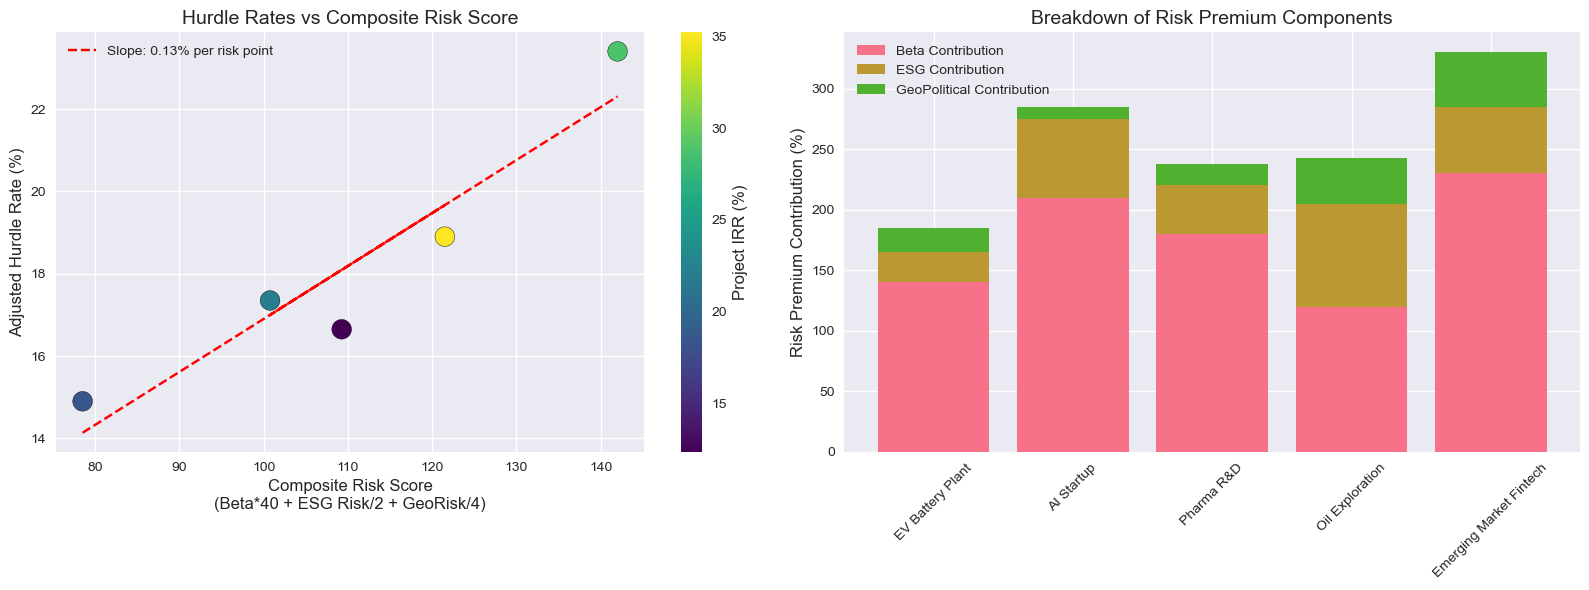


Project Hurdle Rates vs IRR:
EV Battery Plant     Hurdle: 14.9% | IRR: 18.5% → Accept
AI Startup           Hurdle: 18.9% | IRR: 35.2% → Accept
Pharma R&D           Hurdle: 17.3% | IRR: 22.1% → Accept
Oil Exploration      Hurdle: 16.7% | IRR: 12.4% → Reject
Emerging Market Fintech Hurdle: 23.4% | IRR: 28.7% → Accept


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Configure style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Sample data - modern risk factors
projects = {
    'Project': ['EV Battery Plant', 'AI Startup', 'Pharma R&D', 'Oil Exploration', 'Emerging Market Fintech'],
    'Beta': [1.4, 2.1, 1.8, 1.2, 2.3],
    'ESG_Risk': [25, 65, 40, 85, 55],  # Lower = better
    'GeoPolitical_Risk': [40, 20, 35, 75, 90],  # Higher = riskier
    'IRR': [18.5, 35.2, 22.1, 12.4, 28.7]
}

# Base parameters
risk_free_rate = 0.04
market_risk_premium = 0.06
base_esg_premium = 0.02  # 2% premium for ESG risks
geo_risk_multiplier = 0.0005  # 0.05% per risk point

def calculate_hurdle_rate(beta, esg_risk, geo_risk):
    """Calculate dynamic hurdle rate with risk adjustments"""
    capm = risk_free_rate + beta * market_risk_premium
    esg_adj = base_esg_premium * (esg_risk/100)
    geo_adj = geo_risk_multiplier * geo_risk
    return capm + esg_adj + geo_adj

# Calculate hurdle rates
hurdle_rates = [calculate_hurdle_rate(beta, esg, geo) * 100
                for beta, esg, geo in zip(projects['Beta'],
                                        projects['ESG_Risk'],
                                        projects['GeoPolitical_Risk'])]

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hurdle Rate vs Project Risk Profile
risk_scores = [beta*40 + esg/2 + geo/4 for beta, esg, geo in
             zip(projects['Beta'], projects['ESG_Risk'], projects['GeoPolitical_Risk'])]

scatter = ax1.scatter(risk_scores, hurdle_rates, c=projects['IRR'],
                     s=200, cmap='viridis', edgecolor='k')
ax1.set_title('Hurdle Rates vs Composite Risk Score', fontsize=14)
ax1.set_xlabel('Composite Risk Score\n(Beta*40 + ESG Risk/2 + GeoRisk/4)', fontsize=12)
ax1.set_ylabel('Adjusted Hurdle Rate (%)', fontsize=12)
cbar = fig.colorbar(scatter, ax=ax1)
cbar.set_label('Project IRR (%)', fontsize=12)

# Add regression line
slope, intercept, _, _, _ = linregress(risk_scores, hurdle_rates)
ax1.plot(risk_scores, np.array(risk_scores)*slope + intercept,
        'r--', label=f'Slope: {slope:.2f}% per risk point')
ax1.legend()

# Plot 2: Risk Component Breakdown
risk_types = ['Beta', 'ESG', 'GeoPolitical']
components = np.array([projects['Beta'],
                      np.array(projects['ESG_Risk'])/100,
                      np.array(projects['GeoPolitical_Risk'])/200])

bottom = np.zeros(len(projects['Project']))
for i, (risk, component) in enumerate(zip(risk_types, components)):
    ax2.bar(projects['Project'], component*100, bottom=bottom,
           label=f'{risk} Contribution')
    bottom += component*100

ax2.set_title('Breakdown of Risk Premium Components', fontsize=14)
ax2.set_ylabel('Risk Premium Contribution (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

# Print hurdle rate comparison
print("\nProject Hurdle Rates vs IRR:")
for proj, hr, irr in zip(projects['Project'], hurdle_rates, projects['IRR']):
    decision = "Accept" if irr > hr else "Reject"
    print(f"{proj:<20} Hurdle: {hr:.1f}% | IRR: {irr:.1f}% → {decision}")

In [21]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']